# `01_logistic_regression_baseline.ipynb`

In this notebook I perform sentiment analysis on 'Google Reviews of Medical Facilities' from [Kaggle]("https://www.kaggle.com/datasets/cgrowe96/google-reviews-of-us-medical-facilities") using TF-IDF and Logistic Regression (`sklearn`)

## Preparation

### Imports

In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import joblib
import numpy as np
import sys
sys.path.append("../scripts")
from evaluation import evaluate_model

c:\Users\James\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and Clean Data

In [ ]:
df = pd.read_csv("../data/raw_data.csv")

print(df.shape)
print(df.columns.tolist()[:50])

cols_needed = ['Review Text', 'label']

df = df[cols_needed]

df = df.dropna(subset=['Review Text', 'label'])

df = df[df['label'].isin(['positive', 'negative'])].copy()

print("After cleaning rows:", df.shape)
print(df['label'].value_counts())

cleaned_path = "../data/cleaned_reviews.csv"
df.to_csv(cleaned_path, index=False, encoding="utf-8")
print(f"Cleaned data saved to: {cleaned_path}")

(233024, 21)
['Unnamed: 0', 'Author', 'Review Text', 'Review Rating', 'Date', 'Owner Answer', 'Owner Answer Date', 'Author Profile', 'Author Image', 'Review URL', 'label', 'zip', 'spill1', 'spill2', 'spill3', 'spill4', 'spill5', 'spill7', 'spill7.1', 'spill8', 'state']
After cleaning rows: (202047, 2)
label
positive    116273
negative     85774
Name: count, dtype: int64
Cleaned data saved to: data/cleaned_reviews.csv


### Process Review Text using regex

In [3]:
def clean_text(text):
    """Cleans and standardises raw text data for NLP tasks.

    This function performs a series of cleaning operations to prepare a review
    for analysis. It handles case normalisation, and removes HTML tags,
    URLs, emails, and special characters.

    Args:
        text (str): The raw text string (review text) to be cleaned.

    Returns:
        str: The cleaned and standardised review text string.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r"[^a-z0-9\s']", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['Review Text'].astype(str).apply(clean_text)

print(df['clean_text'].sample(5).tolist())

['that hospital is a complete disaster joke i waited nearly 6 hours to been seen i am 63 years old with a hip problem and was never seen i will never go back i can t believe the way the treat people', "i got in quickly for my surgery the surgery team was reliable and able and very friendly ive had billing problems with chi in the past and i am not looking forward to hearing from them again and again when they decide i haven't paid enough my son had an er visit june of 2023 and they have collected money from us multiple times and have been paid by the insurance last week we heard from them again and they are trying to get more money overall good experience at the hospital but the billing department doesn't have a clue what they are doing", 'dr joseph martin was so patient great and kind i have severe anxiety and i am constantly worried about my health and tend to go to er s the second i feel something is wrong in my experiences they are quick to get rid of me once they realize it s anxi

### Split into Train and Test sets

In [4]:
X = df['clean_text']
y = df['label'].map({'negative': 0, 'positive': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])
print("Train label distribution:\n", y_train.value_counts(normalize=True))

Train size: 161637 Test size: 40410
Train label distribution:
 label
1    0.575475
0    0.424525
Name: proportion, dtype: float64


## Modelling

In [5]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5,
        max_df=0.95,
        max_features=50000,
        sublinear_tf=True,
        stop_words=None
    )),
    ('clf', LogisticRegression(
        solver='saga',
        penalty='l2',
        C=1.0,
        max_iter=1000,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


## Prediction and Analysis

### Performance Metrics

Accuracy: 0.9683
F1 Score: 0.9721

Class: negative
 Precision: 0.9509
 Recall:    0.9756
 F1 Score:  0.9631

Class: positive
 Precision: 0.9816
 Recall:    0.9628
 F1 Score:  0.9721


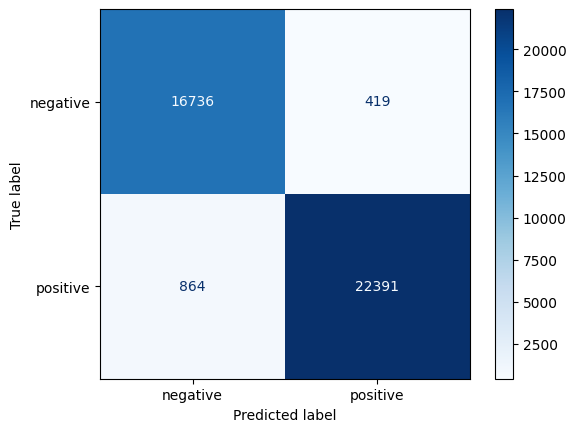

In [6]:
label_names = ["negative", "positive"]
y_true, y_pred, probs = evaluate_model(
    pipeline, X_test=X_test, y_test=y_test, label_names=label_names, return_probs=True
)

Not bad at all for a simple model.

### Saving the model in `pickle` format

In [ ]:
joblib.dump(pipeline, "../models/sentiment_tfidf_logreg.pkl")
print("Saved model to ../models/sentiment_tfidf_logreg.pkl")

Saved model to sentiment_tfidf_logreg.pkl


### Identifying the most influential words

In [8]:
vec = pipeline.named_steps['tfidf']
clf = pipeline.named_steps['clf']

feature_names = vec.get_feature_names_out()
coefs = clf.coef_[0]
top_n = 20

top_pos_idx = np.argsort(coefs)[-top_n:][::-1]
top_neg_idx = np.argsort(coefs)[:top_n]

print("Top positive features:")
print(feature_names[top_pos_idx])
print("\nTop negative features:")
print(feature_names[top_neg_idx])

Top positive features:
['great' 'amazing' 'excellent' 'thank' 'thank you' 'best' 'wonderful'
 'awesome' 'friendly' 'the best' 'love' 'everyone' 'professional' 'good'
 'caring' 'always' 'kind' 'quickly' 'quick' 'fantastic']

Top negative features:
['rude' 'worst' 'horrible' 'not' 'unprofessional' 'terrible' 'no' 'poor'
 'told' 'don' 'never' 'hours' 'worse' 'joke' 'dirty' 'awful' 'ridiculous'
 'the worst' 'money' 'not recommend']


### Misclassification Analysis

In [9]:
# 1. Build results DataFrame
test_results = pd.DataFrame({
    'text': X_test,
    'true_label': y_test.map({0: 'negative', 1: 'positive'}),
    'pred_label': y_pred,
    'prob_negative': probs[:, 0],
    'prob_positive': probs[:, 1]
})
test_results['pred_label'] = test_results['pred_label'].map({0: 'negative', 1: 'positive'})

# 2. Filter misclassified
misclassified = test_results[test_results['true_label'] != test_results['pred_label']]
print(f"Misclassified: {len(misclassified)} / {len(test_results)} ({len(misclassified)/len(test_results):.2%})")

# 3. Show a sample of errors
print("\nSample misclassified reviews:")
display(misclassified.sample(10, random_state=42)[['text', 'true_label', 'pred_label', 'prob_positive']])

# 4. Top words pushing errors (FP = false positives, FN = false negatives)
vec = pipeline.named_steps['tfidf']
clf = pipeline.named_steps['clf']
feature_names = np.array(vec.get_feature_names_out())
coefs = clf.coef_[0]

Misclassified: 1283 / 40410 (3.17%)

Sample misclassified reviews:


,text,true_label,pred_label,prob_positive
57157,i have always taken my children to wesley for ...,negative,positive,0.948336
164397,i do have to admit i have to give lots of them...,positive,negative,0.167097
113687,the nurses were absolutely amazing best nurses...,positive,negative,0.246919
57054,there are good doctors at this place,positive,negative,0.391463
1796,service was great but hearing the staff bash o...,negative,positive,0.740925
24842,i had a good experience at st joseph medical c...,negative,positive,0.857833
196026,i would like to thank you for getting my husba...,negative,positive,0.889868
106118,we have never left a review of this type for a...,positive,negative,0.485120
225521,yes there are quite a few that are nice and ve...,negative,positive,0.690405
92779,went to psych ward wasn t feeling well and tol...,positive,negative,0.171358


In [10]:
def top_error_words(texts, direction, top_n=10):
    """Identifies the most indicative words for a given prediction direction.

    This function analyses a collection of text documents to find the words
    that have the highest or lowest coefficients, based on the model's
    coefficients and feature names. It uses a vectorizer's analyser to
    tokenise the text and then scores each word.

    Args:
        texts (list of str): A list of text documents to analyze.
        direction (str): The direction of interest, either 'positive' or 'negative'.
                         'positive' returns words with high positive coefficients,
                         while 'negative' returns words with high negative coefficients.
        top_n (int, optional): The number of top words to return. Defaults to 10.

    Returns:
        list of tuple: A list of tuples, where each tuple contains the word (str),
                       its coefficient (float), and its frequency count (int) in the
                       input texts. The list is sorted in descending order based on
                       the specified direction.

    Raises:
        ValueError: If `direction` is not 'positive' or 'negative'.
    """
    # Rest of the function code...
    analyzer = vec.build_analyzer()
    from collections import Counter
    counts = Counter()
    for doc in texts:
        counts.update(analyzer(doc))
    scored = []
    for word, cnt in counts.items():
        if word in feature_names:
            idx = np.where(feature_names == word)[0][0]
            scored.append((word, coefs[idx], cnt))
    if direction not in ['positive', 'negative']:
        raise ValueError("Direction must be 'positive' or 'negative'.")
    key = (lambda x: x[1]) if direction == 'positive' else (lambda x: x[1] * -1)
    return sorted(scored, key=key, reverse=True)[:top_n]

fp = misclassified[(misclassified['pred_label'] == 'positive') & (misclassified['true_label'] == 'negative')]
fn = misclassified[(misclassified['pred_label'] == 'negative') & (misclassified['true_label'] == 'positive')]

print("\nWords pushing toward POSITIVE in false positives:")
for w, c, n in top_error_words(fp['text'], 'positive'):
    print(f"{w:15} coef={c:.2f} count={n}")

print("\nWords pushing toward NEGATIVE in false negatives:")
for w, c, n in top_error_words(fn['text'], 'negative'):
    print(f"{w:15} coef={c:.2f} count={n}")


Words pushing toward POSITIVE in false positives:
great           coef=12.55 count=92
amazing         coef=10.74 count=32
excellent       coef=10.68 count=23
thank           coef=10.08 count=39
thank you       coef=9.57 count=32
best            coef=9.42 count=44
wonderful       coef=8.75 count=25
awesome         coef=7.54 count=9
friendly        coef=7.22 count=19
the best        coef=6.62 count=30

Words pushing toward NEGATIVE in false negatives:
rude            coef=-11.90 count=71
worst           coef=-10.76 count=31
horrible        coef=-10.31 count=37
not             coef=-10.08 count=676
unprofessional  coef=-7.98 count=14
terrible        coef=-7.96 count=23
no              coef=-7.60 count=286
poor            coef=-6.73 count=14
told            coef=-6.38 count=215
don             coef=-6.19 count=159


Strong overlap with the most positive and most negative features. This further displays how Logistic Regression is insufficient for modelling context and how necessary a BERT model is for mitigating these types of misclassifications.